In [1]:
%matplotlib inline

import os

import matplotlib
import matplotlib.pyplot as pyplot
import geopandas as gpd
import numpy as np

from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.affinity import scale

import shapely.ops

from tileable import TileShape
from tile_unit import TileUnit
from tile_map import Tiling

In [2]:
def get_filename_label(path):
    fname = os.path.basename(path)
    return fname.partition("-")[0]

## Get the data

In [3]:
path1 = "../data/002448-results-GWR_fixbw-COVID_cases_per_1000persons__over_both_periods-regen-BlackAsianHispanic-life_expect-econ_sect_shares.gpkg"

path2 = "../data/006092-results-GWR_fixbw-COVID_cases_per_1000persons__over_period_1-BlackAsianHispanic.gpkg"

gwr1 = gpd.read_file(path1)
gwr1["ID"] = list(range(gwr1.shape[0]))

gwr2 = gpd.read_file(path2)
gwr2["ID"] = list(range(gwr2.shape[0]))

In [4]:
states = gpd.read_file("../data/Agriculture-COVID.gpkg")
states = states.dissolve(
    by = "STATE_FIPS")[["STATE", "geometry"]].to_crs(gwr1.crs)

In [5]:
d = 50000
tile_inset = 1000

## A H3 (or 7-colouring) tile unit
This is a 7 colouring of the tiling by regular hexagons.

<AxesSubplot:>

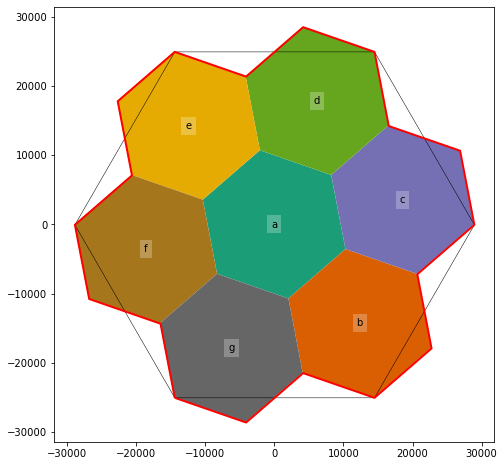

In [6]:
# make a base tile to start
hex_7_tile = TileUnit(tiling_type = "hex-colouring", n = 7,
                      spacing = d, crs = gwr1.crs)
hex_7_tile.plot()

Use it to tile the states

In [7]:
states_tiling = Tiling(hex_7_tile, states, id_var = "STATE")
states_hex7_layer = states_tiling.get_tiled_map(
    rotation = 10, prioritise_tiles = True).tiled_map
states_hex7_layer.geometry = states_hex7_layer.geometry.buffer(
    1e-3, join_style = 2)
states_hex7_layer = states_hex7_layer.dissolve(
        by = "STATE", as_index = False)
states_hex7_layer.geometry = states_hex7_layer.geometry.buffer(-1e-3)

Now tile the data map, but this time apply a tile margin.

In [8]:
hex7_tiling = Tiling(hex_7_tile, gwr1, id_var = "ID", tile_margin = tile_inset)
hex7_map = hex7_tiling.get_tiled_map(
    rotation = 10, prioritise_tiles = True)

Make up variable and colourmap lookups

In [9]:
betas7 = [n for n in gwr1.columns if "_beta_classified" in n]
hex7_map.variables = dict(zip(list("gbcdefa"), betas7))
hex7_map.colourmaps =  dict(zip(
    betas7, 7 * [{'associated with LESS covid': "#69A7CF",
                  'not significant': "#C7C7C7",
                  'associated with MORE covid': "#EF8A62"}]))
hex7_map.dpi = 150
hex7_map.figsize = (24, 18)

And make a map

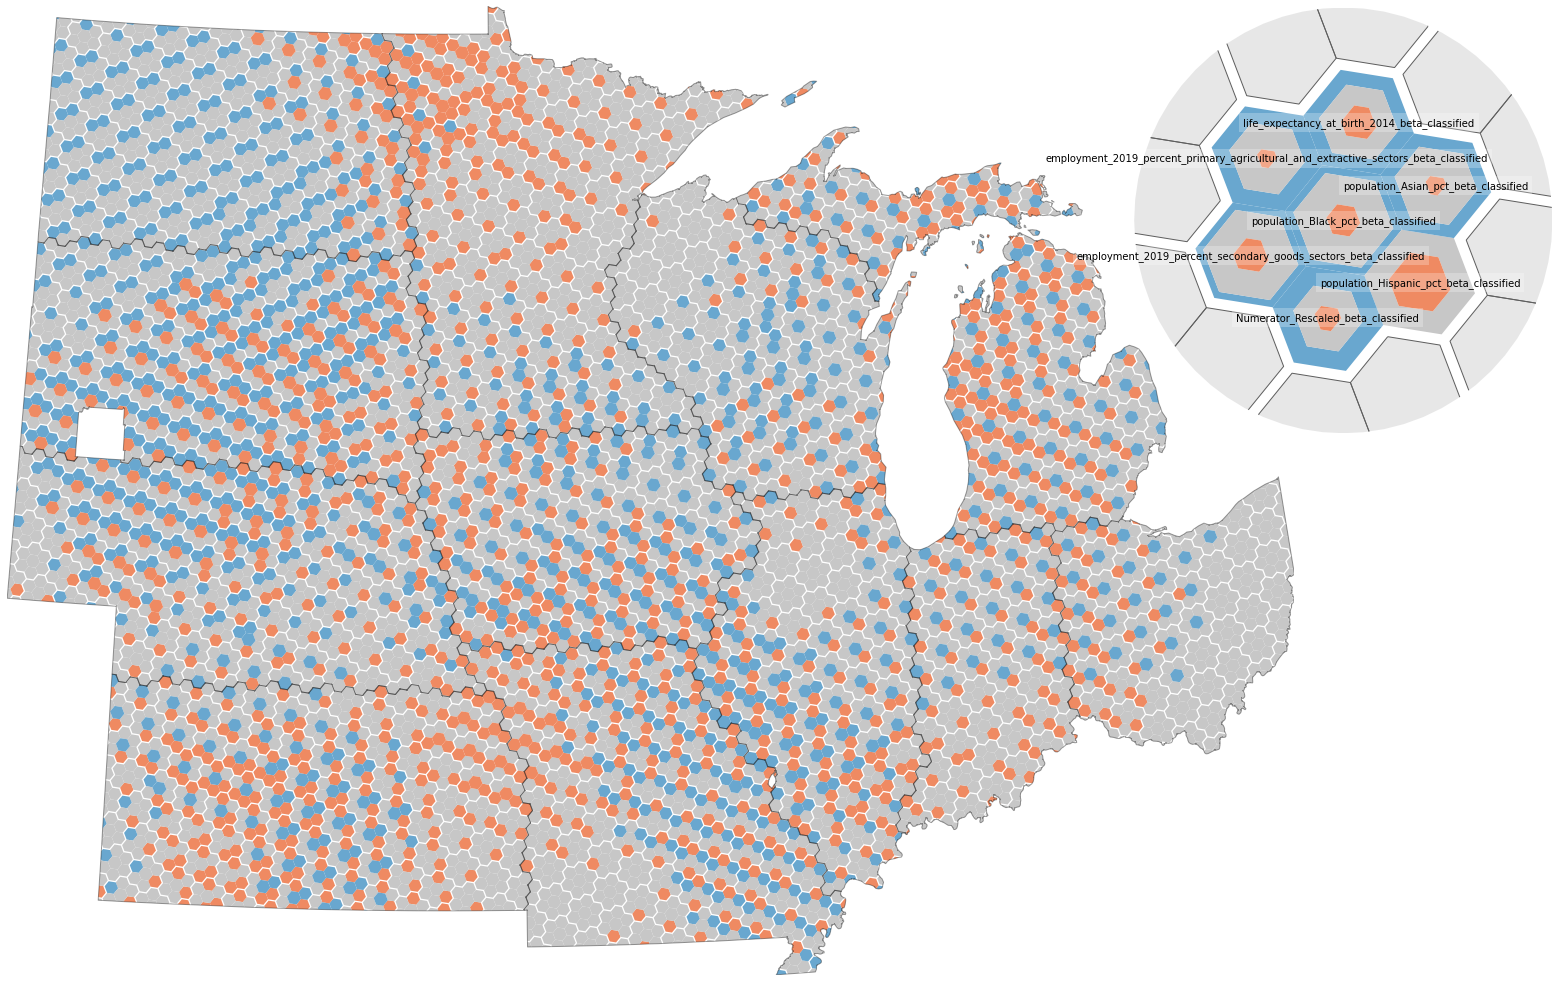

In [10]:
fig = hex7_map.render(
    legend_zoom = 1., legend_dx = -0.1, legend_dy = -0.125,
    use_ellipse = True, ellipse_magnification = 1)
states_hex7_layer.plot(ax = fig.get_axes()[0], fc = "#00000000", 
                       ec = "#00000060", lw = 1)

fig.savefig(f"hex_{get_filename_label(path1)}.pdf")

## Hex 3-colouring tile unit
A 3-colourable tiling of regular hexagons. Not yet implemented, so make it by hand here.

<AxesSubplot:>

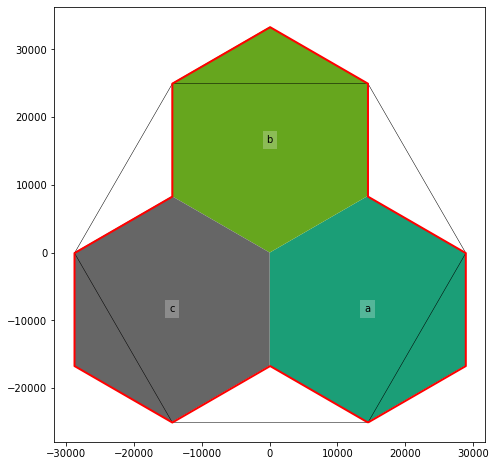

In [11]:
hex_3_tile = TileUnit(tiling_type = "hex-coloring", n = 3,
                      spacing = d, crs = gwr2.crs)
hex_3_tile.plot()

In [12]:
# this is the rotation of the 7-colouring
rotation = np.degrees(np.arctan(1 / 3 / np.sqrt(3)))

states_tiling = Tiling(hex_3_tile, states, id_var = "STATE")
states_hex3_layer = states_tiling.get_tiled_map(
    rotation = rotation + 10, prioritise_tiles = True).tiled_map
states_hex3_layer.geometry = states_hex3_layer.geometry.buffer(
    1e-3, join_style = 2)
states_hex3_layer = states_hex3_layer.dissolve(
        by = "STATE", as_index = False)
states_hex3_layer.geometry = states_hex3_layer.geometry.buffer(-1e-3)

In [13]:
hex3_tiling = Tiling(hex_3_tile, gwr2, id_var = "ID", tile_margin = tile_inset)
hex3_map = hex3_tiling.get_tiled_map(
    rotation = rotation + 10, prioritise_tiles = True)

In [14]:

betas3 = [n for n in gwr2.columns if "_beta_classified" in n]
hex3_map.variables = dict(zip(list("cab"), betas3))
hex3_map.colourmaps =  dict(zip(
    betas3, 3 * [{'associated with LESS covid': "#69A7CF",
                  'not significant': "#C7C7C7",
                  'associated with MORE covid': "#EF8A62"}]))
hex3_map.dpi = 150
hex3_map.figsize = (24, 18)

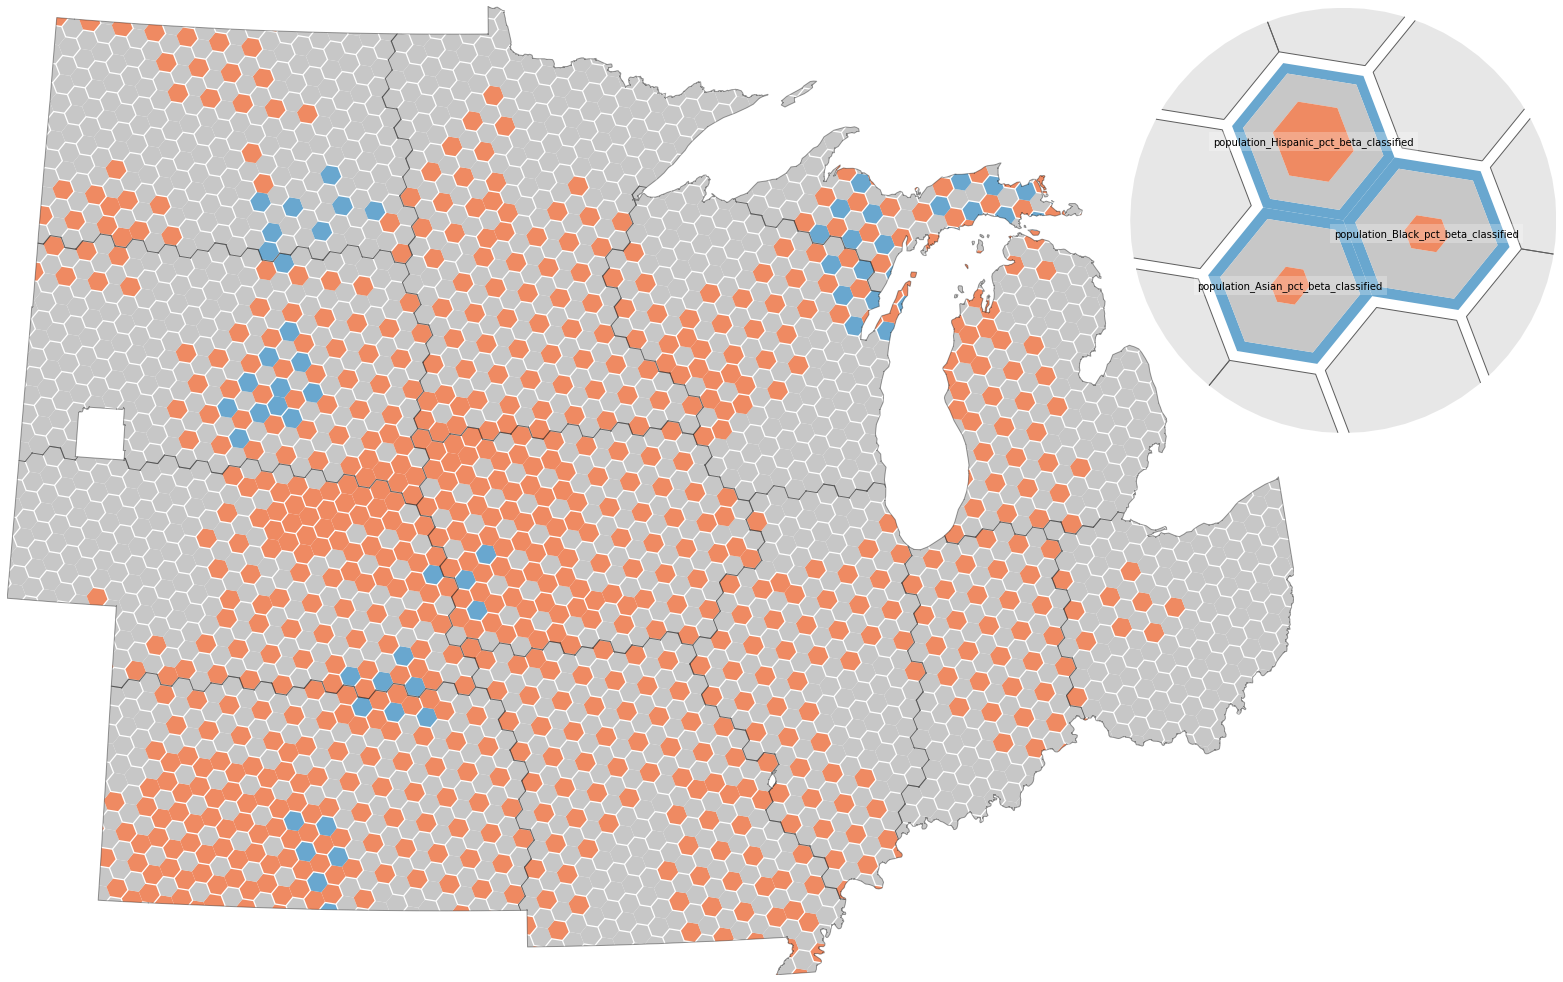

In [15]:
fig = hex3_map.render(legend_zoom = 1.0, legend_dx = -0.1, legend_dy = -0.125, 
                      use_ellipse = True, ellipse_magnification = 1.0)
states_hex3_layer.plot(ax = fig.get_axes()[0], fc = "#00000000", 
                       ec = "#00000060", lw = 1)

fig.savefig(f"hex_{get_filename_label(path2)}.pdf")